# Example: Exploring Crosstalk Results (SLAC USDF)

Last Verified to Run: 2022-10-25<br>
Verified Stack Release: v23.0.0

## Introduction

MixCOATL was developed to be compatible with the Butler Gen 3 Repository to organize and store the results of the crosstalk analyses. The purpose of this notebook is to serve as a tutorial for interacting with and exploring the Gen 3 Repository. The data products shown here were generated by running the `mixcoatl.crosstalkTask.CrosstalkSpotTask` on a number of images taken at the SLAC National Accelerator Laboratory during the integration and testing of the Rubin Observatory LSST Camera.

In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   g0b29ad24fb+959269e436 	d_2022_10_12 w_latest w_2022_42 current d_latest setup


First import some general Python packages, DM Stack objects, and MixCOATL utilities.  The `AMP2SEG` and `SEG2AMP` objects are dictionaries that provide convenient mapping between amplifier number (1-16) and segment naming convention (C00, C01, etc.)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np
from scipy.stats import binned_statistic

## DM Stack imports
from lsst.daf.butler import Butler

## MixCOATL imports
from mixcoatl.utils import AMP2SEG, SEG2AMP

## Gen 3 repo for BOT data
repo = '/sdf/group/rubin/repo/main'

## Exploring a Gen 3 Repository

A `Butler` object can be initialized using the filepath to the repository YAML file. The BOT Gen 3 repository is located at `/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data` and accessible via the SLAC Shared Data Facility (SDF). While the `Butler` itself is used for retrieving a dataset from the repository, the `registry` is useful for performing queries on datasets, exploring "collections" of datasets, and determining dataset types.

In [3]:
butler = Butler(repo)
registry = butler.registry

Within the BOT repository there are large number of collections of various types (RUN, TAGGED, CALIBRATION, CHAINED). These include the main raw data collection (`LSSTCam/raw/all`), curated calibration collection (`LSSTCam/calib`), and collections corresponding to individual analysis runs. Below we use the `registry` to query and print only the RUN collections associated with the crosstalk analysis.

In [4]:
## Display collections in the repository
collections = list(registry.queryCollections('u/snyder18/*/crosstalk*'))
collections.sort()
                   
for collection in collections:
    print(collection)

u/snyder18/13198/crosstalk_analysis
u/snyder18/13198/crosstalk_analysis/20221025T191836Z
u/snyder18/13199/crosstalk_analysis
u/snyder18/13199/crosstalk_analysis/20221023T005204Z
u/snyder18/13224/crosstalk_spot
u/snyder18/13224/crosstalk_spot/20221020T224302Z
u/snyder18/13241/crosstalk_satellite
u/snyder18/13241/crosstalk_satellite/20221021T210543Z


When querying the repository for dataset references it is important to know the fields available for query. This can be determined using the `registry`.

In [5]:
## Display list of dataset fields
print(registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  day_obs: int
  seq_num: int
  seq_start: int
  seq_end: int
  group_name: str
  group_id: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  azimuth: float
  zenith_angle: float
  has_simulated: bool
  timespan: lsst.daf.butler.Timespan


# Crosstalk Analysis Results

To obtain the results corresponding to the analysis of the BOT Run 5 data, first the dataset references for the calibrated images within the corresponding collection are obtained using the `registry`, by specifying the dataset type and the collection.

For the crosstalk analysis, the relevant dataset types are:

* `raw`: The raw CCD image.
* `cpCrosstalkProc`: The post-ISR CCD image used for the crosstalk analysis.
* `bias`: The calibration superbias CCD image used during ISR.
* `crosstalkCoefficients`: The crosstalk coefficient determined by the best fit model methodology.
* `crosstalkSignals`: The source signal associated with each best fit model determination.
* `crosstalkRatios`: The pixel-by-pixel ratios measured from each post-ISR CCD image.
* `crosstalkFluxes`: The source flux for each pixel-by-pixel ratio measurement.
* `crosstalkBackgroundZOffsets`: The z-offset value of the background plane measured from each post-ISR CCD image.
* `crosstalkBackgroundYTilts`: The y-tilt value of the background plane measured from each post-ISR CCD image.
* `crosstalkBackgroundXTilts`: The x-tilt value of the background plane measured from each post-ISR CCD image.

## Crosstalk Image Example

As an example we will start with the collection `u/snyder18/13224/crosstalk_spot`, which is data run 13224 consisting of crosstalk images for a range of exposure times on four different CCDs (58, 76, 139, 166). To get the `cpCrosstalkProc` datasets we start by constructing an SQL-like query and select the RUN collection corresponding to the analysis of this data run.  The `registry.queryDatasets()` method is used to get a generator of the dataset references corresponding to our query that can be converted into a list and sorted by exposure ID.

In [6]:
## Construct dataset query
run_num = 13224
detector = 58

collections = 'u/snyder18/{0}/crosstalk_spot'.format(run_num)
where = "instrument='LSSTCam'" + \
    " and exposure.observation_type='xtalk'" + \
    " and detector={0}".format(detector) + \
    " and exposure.science_program='{0}'".format(run_num)

dataset_refs = list(registry.queryDatasets('cpCrosstalkProc', collections=collections,
                                           where=where))
dataset_refs.sort(key=lambda x: x.dataId['exposure'])
print('Number of calibrated images: {0}'.format(len(dataset_refs)))

Number of calibrated images: 400


An example `cpCrosstalkProc` dataset is obtained by selecting a dataset reference from the list of dataset references and using the `butler.get()` method. Each crosstalk image consists of four larger spots projected onto four different CCD segments; this allows the measurement of crosstalk for 4 of the 16 CCD segments in a single image.

Text(0.5, 1.0, 'R13/S11 cpCrosstalkProc: 3021122000691')

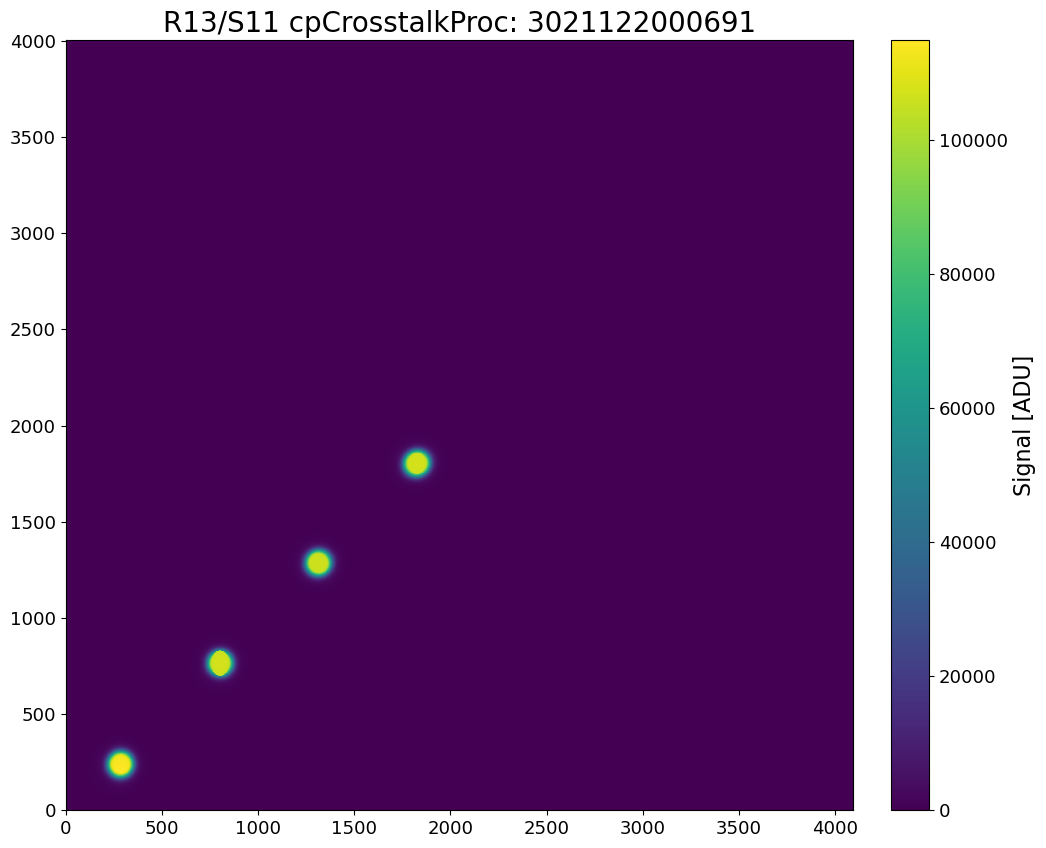

In [7]:
## Get calibrated exposure
ref = dataset_refs[345]
data_id = ref.dataId['exposure']
calexp = butler.get(ref, collections=collections)
raft_name, sensor_name = calexp.getDetector().getName().split('_')

## Display calibrated image
fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')
im = ax.imshow(calexp.getImage().getArray(), interpolation='none', origin='lower')
    
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Signal [ADU]', fontsize=16)
cbar.ax.tick_params(labelsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_title('{0}/{1} cpCrosstalkProc: {2}'.format(raft_name, sensor_name, data_id), fontsize=20)

It is easy to obtain datasets associated with a specific dataset reference using the `butler.get()` method, although the syntax is modified slightly.  If we wish to obtain the `crosstalkCoefficients` dataset, which contains all of the crosstalk ratio measurements made from the `cpCrosstalkProc` dataset, we must specify our desired dataset type and the data ID of the dataset reference.

The `crosstalkCoefficients` dataset is a `StructuredDataDict` object, consisting of a set of nested dictionaries, from which a crosstalk matrix can be made by iteratively collecting crosstalk ratio values. The ordering of dictionary keys is source sensor name (e.g. `R13_S11`), target sensor name (identical to the source sensor), the source segment name (e.g. `C00`), and the target segment name (e.g. `C01`).  The source segment name indicates the segment where one of the large spots that serves as a source of crosstalk is located, while the target segment name refers to a different segment where we are measuring the amplitude of any induced electronic ghost.

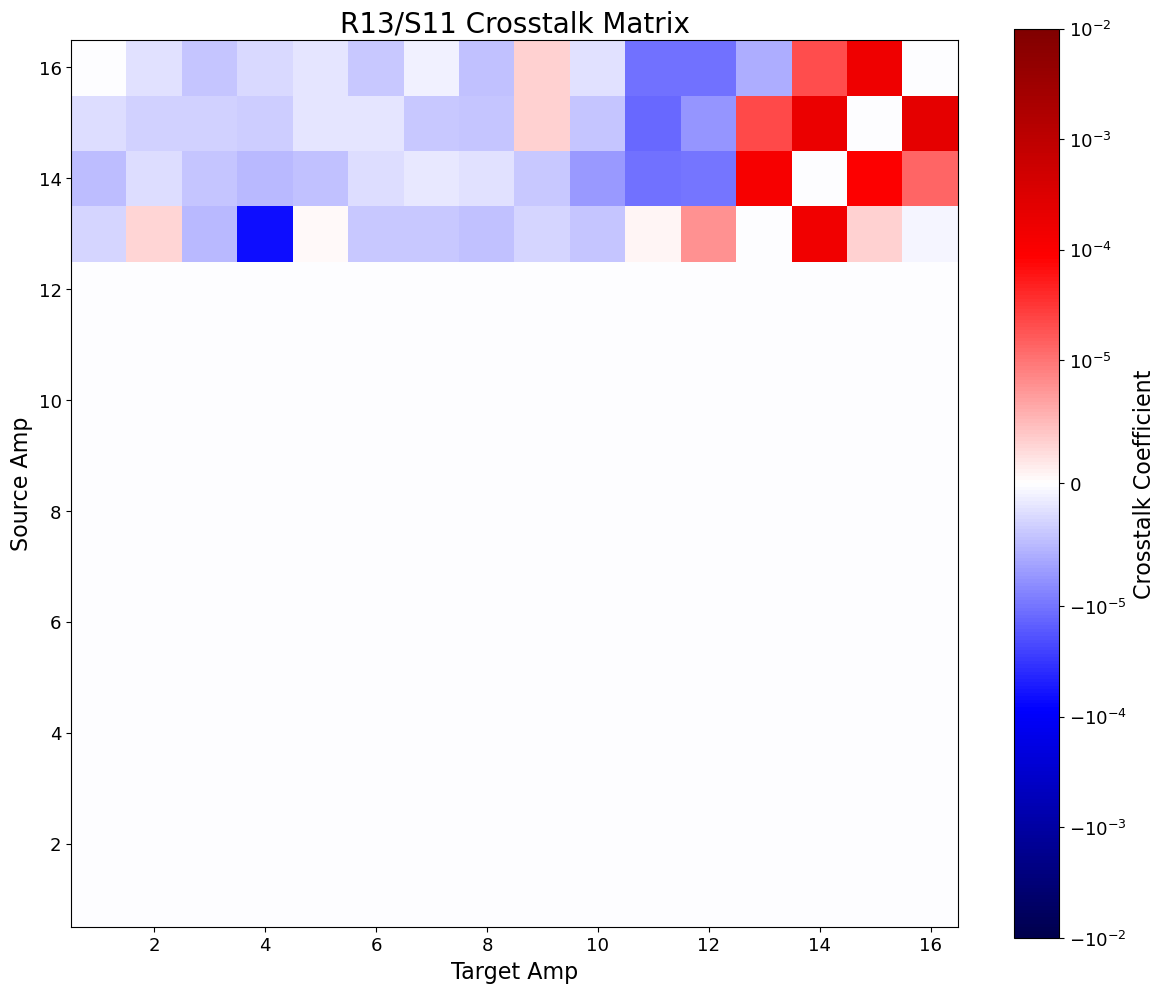

In [8]:
## Get corresponding ratio results
ratios = butler.get('crosstalkCoefficients', dataId=ref.dataId, collections=collections)

## Iterate through source/target segment dictionaries
xtalk_matrix = np.zeros((16, 16))

sensor_id = '{0}_{1}'.format(raft_name, sensor_name)
for target_segment in ratios[sensor_id][sensor_id].keys():

    target_amp = SEG2AMP[target_segment]

    for source_segment in ratios[sensor_id][sensor_id][target_segment].keys():

        source_amp = SEG2AMP[source_segment]
        
        ## Ignore diagonal terms, else add to the crosstalk matrix array
        if source_segment == target_segment:
            xtalk_matrix[source_amp-1, target_amp-1] = 0.0
        else:
            y = ratios[sensor_id][sensor_id][target_segment][source_segment][0]
            xtalk_matrix[source_amp-1, target_amp-1] = y

## Plot crosstalk matrix
fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')
im = ax.imshow(xtalk_matrix, origin='lower', extent=[0.5, 16.5, 0.5, 16.5], 
               norm=SymLogNorm(1E-5, vmin=-1E-2, vmax=1E-2, base=10), cmap='seismic')
ax.tick_params(axis='both', labelsize=13)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('Crosstalk Coefficient', fontsize=16)
ax.set_title('{0}/{1} Crosstalk Matrix'.format(raft_name, sensor_name), fontsize=20)
ax.set_ylabel('Source Amp', fontsize=16)
ax.set_xlabel('Target Amp', fontsize=16)
plt.tight_layout()

Because the range of crosstalk ratios is large, spanning multiple orders of magnitude, it is best to plot the crosstalk matrix using a symmetric logarithmic scale that displays both positive and negative logarithmic scaling, with a small linearly scaled section around zero, in this case between -1E-5 and 1E-5.

From a single crosstalk image, only four rows of of the 16x16 crosstalk matrix are populated, corresponding to the four possible source segments where the large spots are located. To populate the full matrix, at least 3 additional images are needed, corresponding to three different dither positions of the crosstalk projector.

## Crosstalk Matrix Example

To show this, a second dataset query is demonstrated, this time using the collection `u/snyder18/13199/crosstalk_analysis`, which is data run 13199 consisting of crosstalk images across all focal plane CCDs. While the previous data run stopped after calculating the crosstalk coefficients, this data run continued the analysis by using the `CrosstalkSolveTask` to aggregate and average the crosstalk coefficients for each CCD to generate the full crosstalk matrix.

The crosstalk matrix has the following dataset type:

* `crosstalk`: The crosstalk calibration object for a CCD, containing the crosstalk matrix.

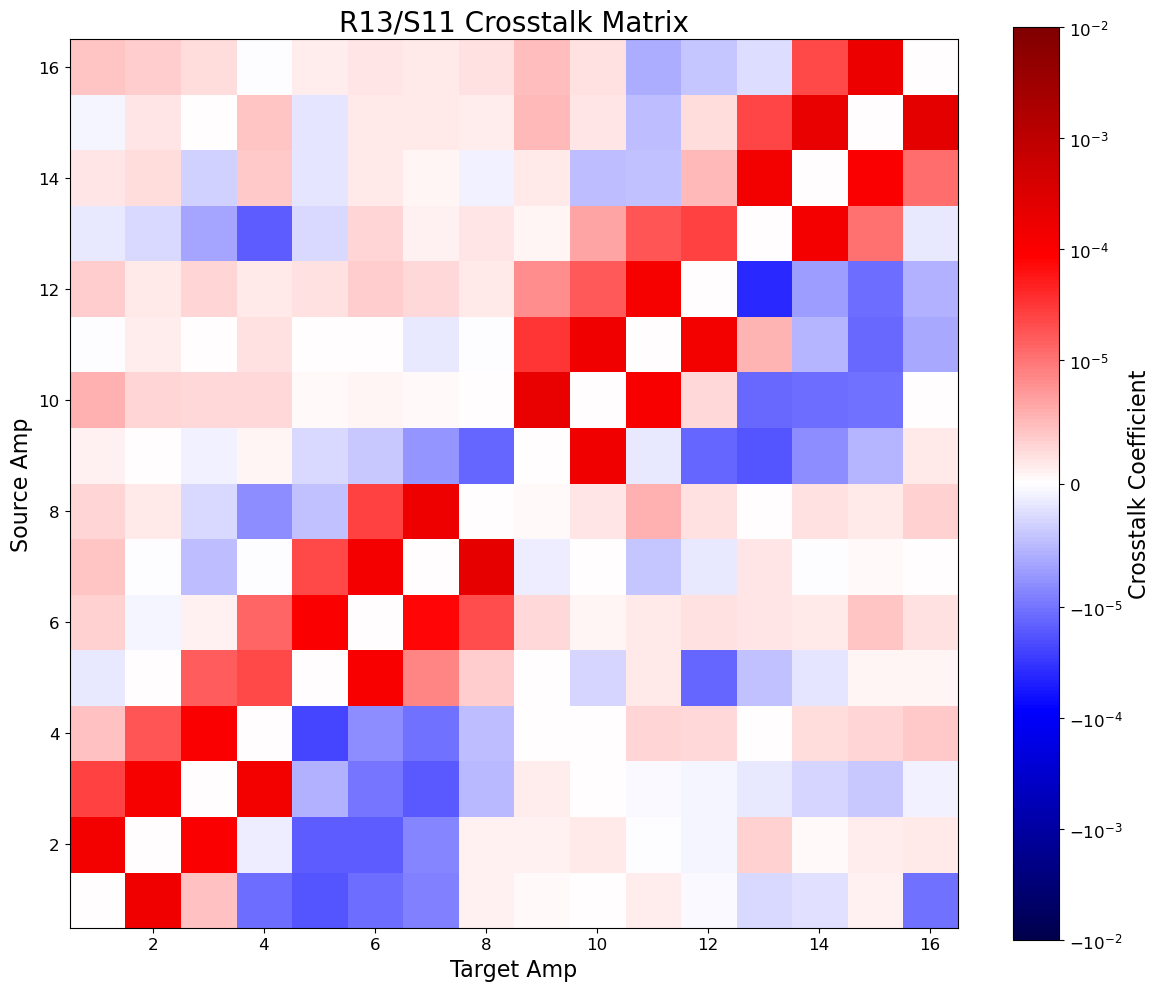

In [9]:
## Construct dataset query
run_num = 13198
detector = 58
collections = 'u/snyder18/{0}/crosstalk_analysis'.format(run_num)
where = "instrument='LSSTCam'" + \
    " and detector={0}".format(detector) + \
    " and exposure.science_program='{0}'".format(run_num)
data_refs = list(registry.queryDatasets('crosstalk', collections=collections,
                                        where=where))

## Get crosstalk calibration object
crosstalk_calib = butler.get(data_refs[0], collections=collections)

## Plot crosstalk matrix
fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')
im = ax.imshow(crosstalk_calib.coeffs.T, origin='lower', extent=[0.5, 16.5, 0.5, 16.5], 
               norm=SymLogNorm(1E-5, vmin=-1E-2, vmax=1E-2, base=10), cmap='seismic')
ax.tick_params(axis='both', labelsize=12)
ax.set_ylabel('Source Amp', fontsize=16)
ax.set_xlabel('Target Amp', fontsize=16)
ax.set_title('{0}/{1} Crosstalk Matrix'.format(raft_name, sensor_name), fontsize=20)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=12) 
cbar.set_label('Crosstalk Coefficient', fontsize=16)
plt.tight_layout()

## Crosstalk Linearity Example

The final example will be of how to access and display the results of crosstalk as a function of signal, used to characterize the crosstalk non-linearity.  As seen from the previous examples there exists crosstalk coefficients for every source/target segment pairing of the 16 CCD segments.  Therefore for this example we use only a single source/target segment pair for illustration, although this same approach can be further expanded to include more segment pairs.

For this example we return to the collection `u/snyder18/13224/crosstalk_spot`. This time instead of only requesting the associated `crosstalkCoefficients`, we will also be querying the butler for the `crosstalkSignals` datasets, which contain the measured signal value of the crosstalk sources. Additionally, we will be using the much larger dataset of associated pixel-by-pixel ratio measurements that are taken for each of the images. These results will be binned up and plotted alongside the results from the model fit method.

Because a single image only projects 4 large spots, some images will not have crosstalk ratio results for some segments, therefore it is necessary to skip these when iterating through datasets.  Here we plot both the individual results and the average over the measurements taken at the same signal level.

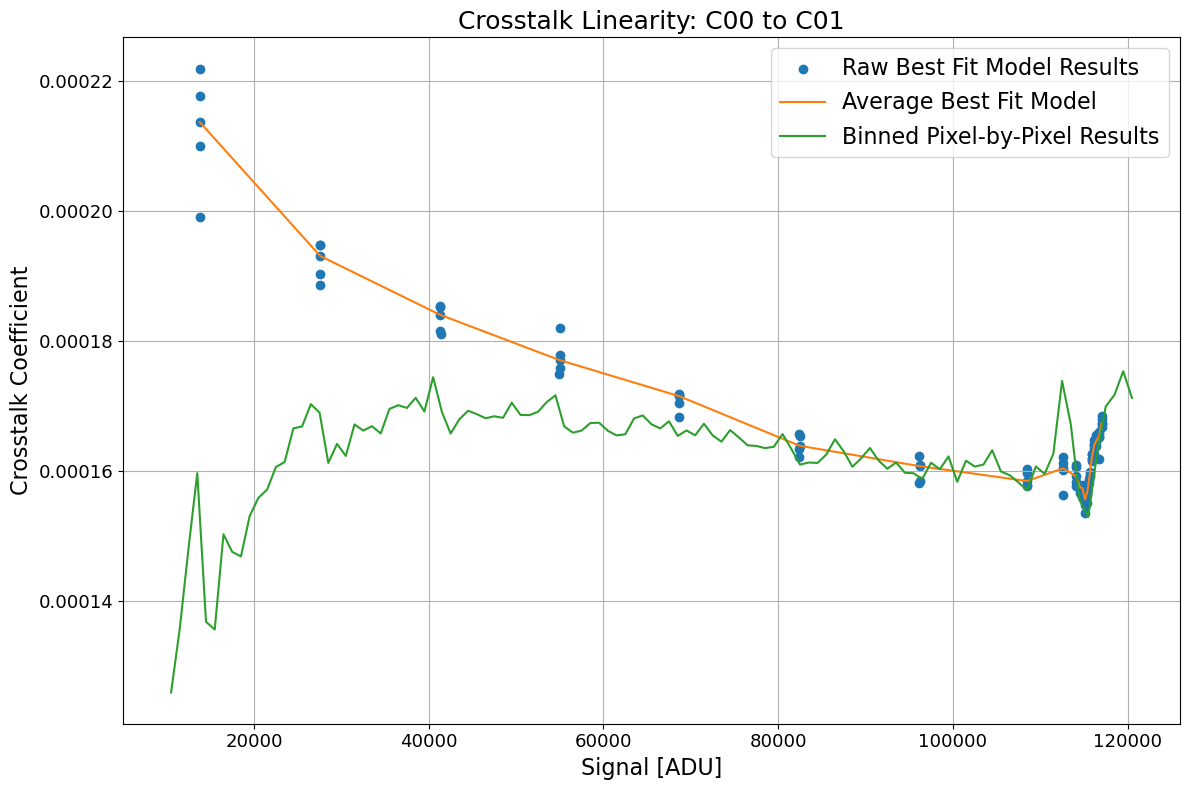

In [10]:
## Construct dataset query
run_num = 13224
detector = 58
collections = 'u/snyder18/{0}/crosstalk_spot'.format(run_num)
where = "instrument='LSSTCam'" + \
    " and exposure.observation_type='xtalk'" + \
    " and detector={0}".format(detector) + \
    " and exposure.science_program='{0}'".format(run_num)

data_refs = list(registry.queryDatasets('crosstalkCoefficients', collections=collections,
                                        where=where))
data_refs = sorted(data_refs, key=lambda x : x.dataId['exposure'])

## Specify sensor, and source/target pair
sensor_id = 'R13_S11'
source_segment = 'C00'
target_segment = 'C01'

bfm_y = []
bfm_x = []

pbp_y = []
pbp_x = []
for ref in data_refs[300:]:
    
    coefficients = butler.get(ref, collections=collections)
    signals = butler.get('crosstalkSignals', dataId=ref.dataId, collections=collections)
    ratios = butler.get('crosstalkRatios', dataId=ref.dataId, collections=collections)
    fluxes = butler.get('crosstalkFluxes', dataId=ref.dataId, collections=collections)
    
    ## Filter out datasets without data for this segment pair
    try:
        bfm_x.append(signals[sensor_id][source_segment][0])
        bfm_y.append(coefficients[sensor_id][sensor_id][target_segment][source_segment][0])

        pbp_y += ratios[sensor_id][sensor_id][target_segment][source_segment]
        pbp_x += fluxes[sensor_id][source_segment]
    except KeyError:
        continue
    
## Bin pixel-by-pixel ratio results
bins = np.arange(10000, np.max(pbp_x), 1000)
bin_coefficients, bin_edges, binnumber = binned_statistic(pbp_x, pbp_y, statistic='median', 
                                           bins=bins)
bin_std, bin_edges, binnumber = binned_statistic(pbp_x, pbp_y, statistic='std', 
                                           bins=bins)
bin_count, bin_edges, binnumber = binned_statistic(pbp_x, pbp_y, statistic='count', 
                                           bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

ax.plot(bin_centers, bin_coefficients, c='C01', label='Binned Pixel-by-Pixel Results')
        
## Calculate median of the 5 model fit measurements per signal level
n = len(bfm_x)
bfm_x = np.asarray(bfm_x)
bfm_y = np.asarray(bfm_y)
median_x = np.median(bfm_x.reshape(n // 5, 5), axis=1)
median_y = np.median(bfm_y.reshape(n // 5, 5), axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), facecolor='white')
cmap = plt.get_cmap("tab10")
ax.scatter(bfm_x, bfm_y, label='Raw Best Fit Model Results', color=cmap(0))
ax.plot(median_x, median_y, label='Average Best Fit Model', color=cmap(1))
ax.plot(bin_centers, bin_coefficients, c=cmap(2), label='Binned Pixel-by-Pixel Results')
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(axis='both', labelsize=13)
ax.set_ylabel('Crosstalk Coefficient', fontsize=16)
ax.set_xlabel('Signal [ADU]', fontsize=16)
ax.set_title('Crosstalk Linearity: {0} to {1}'.format(source_segment, target_segment), fontsize=18)
plt.tight_layout()